# IR Search Engine tests
Values I need:
- term frequencies by document

In [50]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import random

In [51]:
documents = ['Boats are great',
             'Sailing boats are environmental',
             'canal boats are often called narrow boats, they are quite environmental',
             'wooden boats are more work than metal boats',
             'wooden boats are more work than metal boats, but trawlers are the worst',
             'a wooden house is always the prettiest',
             'narrow cars fit through narrow streets and are environmental',
             'boats boats boats']

In [52]:
def term_doc_matrix(documents):
    # Generate term-document matrix
    # Includes some stopword removal that I can't get rid of. Will do this step differently for the real thing.
    vectorizer = CountVectorizer(stop_words=[])
    documents_vectorized = vectorizer.fit_transform(documents)
    vocabulary = vectorizer.get_feature_names_out()
    return pd.DataFrame(documents_vectorized.toarray(), columns=vocabulary)
df = term_doc_matrix(documents)
df

,always,and,are,boats,but,called,canal,cars,environmental,fit,...,sailing,streets,than,the,they,through,trawlers,wooden,work,worst
0,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,2,2,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,0,0,2,2,1,0,0,0,0,0,...,0,0,1,1,0,0,1,1,1,1
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
6,0,1,1,0,0,0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,0
7,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# First step of conditional entropy calculation
def normalise(row):
    return row/row.sum()

df_term_distributions = df.apply(normalise, axis=0)

In [54]:
df_term_distributions

,always,and,are,boats,but,called,canal,cars,environmental,fit,...,sailing,streets,than,the,they,through,trawlers,wooden,work,worst
0,0.0,0.0,0.125,0.090909,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.125,0.090909,0.0,0.0,0.0,0.0,0.333333,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.250,0.181818,0.0,1.0,1.0,0.0,0.333333,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.125,0.181818,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.333333,0.5,0.0
4,0.0,0.0,0.250,0.181818,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.5,0.5,0.0,0.0,1.0,0.333333,0.5,1.0
5,1.0,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.333333,0.0,0.0
6,0.0,1.0,0.125,0.000000,0.0,0.0,0.0,1.0,0.333333,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
7,0.0,0.0,0.000,0.272727,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [55]:
# Second step of conditional entropy calculation
def conditional_entropy_summand(row):
    result = []
    for x in row:
        if x!=0:
            result.append(-x*np.log2(x))
        else:
            result.append(0)
    return pd.Series(result)

# Putting the conditional entropy steps together and summing
def conditional_entropy(df):
    return df.apply(normalise, axis=0).apply(conditional_entropy_summand, axis=0).sum(axis=0)

df_conditional_entropy = conditional_entropy(df)

In [56]:
# Class objects
doc_lens = df.sum(axis=1)
document_terms = [doc.split(' ') for doc in documents]
tokens = [token for doc in document_terms for token in doc]
tokens.remove('a') # TEMPORARY FIX WHILE USING COUNTVECTORIZER
doc_lens

0     3
1     4
2    11
3     8
4    13
5     6
6     9
7     3
dtype: int64

In [57]:
def shuffle_terms(doc_lens, tokens):
    # shuffles tokens over the documents
    # returns a new document list with the terms shuffled
    null_tokens = list(np.random.permutation(tokens))
    null_documents = list()
    start = 0
    
    for i in doc_lens:
        null_documents.append(null_tokens[start:start+i])
        start+=i
    
    null_docs = list()
    for doc in null_documents:
        null_docs.append(' '.join(doc))
    
    return null_docs

In [58]:
null_docs = shuffle_terms(doc_lens, tokens)
null_docs

['than work trawlers',
 'often great environmental narrow',
 'Sailing house prettiest work quite are boats wooden through narrow environmental',
 'boats metal streets are boats are is are',
 'the boats fit the worst environmental called are are boats they canal wooden',
 'boats, are boats boats boats always',
 'boats, but more and more than are narrow cars',
 'Boats wooden metal']

In [59]:
# Create a document-term matrix for the null document set
df_null = term_doc_matrix(null_docs)
df_null

,always,and,are,boats,but,called,canal,cars,environmental,fit,...,sailing,streets,than,the,they,through,trawlers,wooden,work,worst
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,1,0,...,1,0,0,0,0,1,0,1,1,0
3,0,0,3,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,2,2,0,1,1,0,1,1,...,0,0,0,2,1,0,0,1,0,1
5,1,0,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,1,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [64]:
# Calculate conditional entropy for each term in the null model.
df_null_conditional_entropy = conditional_entropy(df_null)

In [65]:
# Shuffle (1000 times) and average the entropies

def null_model_generator(doc_lens, tokens):
    # Shuffle the tokens across the documents
    # Create document-term matrix
    # Normalise the matrix to get distributions of terms across the documents 
    # Calculate the conditional entropy
    # Returns dataframe of conditional entropy of terms
    return conditional_entropy(term_doc_matrix(shuffle_terms(doc_lens, tokens)))

def null_model_iterator(n, doc_lens, tokens):
    # Iterates the null_model_generator n times and takes the mean of the results
    null_sum = null_model_generator(doc_lens,tokens)
    for i in range(n-1):
        null_sum += null_model_generator(doc_lens,tokens)
    return null_sum/n

df_null_mean = null_model_iterator(1000, doc_lens, tokens)
df_null_mean

always           0.000000
and              0.000000
are              2.170395
boats            2.379459
but              0.000000
called           0.000000
canal            0.000000
cars             0.000000
environmental    1.307100
fit              0.000000
great            0.000000
house            0.000000
is               0.000000
metal            0.859000
more             0.873000
narrow           1.297162
often            0.000000
prettiest        0.000000
quite            0.000000
sailing          0.000000
streets          0.000000
than             0.865000
the              0.861000
they             0.000000
through          0.000000
trawlers         0.000000
wooden           1.318597
work             0.859000
worst            0.000000
dtype: float64

In [68]:
# Calculate the information content of each term: a measure of how different it behaves from the average null model
info_content = df_null_mean - df_conditional_entropy
info_content

always           0.000000
and              0.000000
are             -0.329605
boats           -0.102255
but              0.000000
called           0.000000
canal            0.000000
cars             0.000000
environmental   -0.277863
fit              0.000000
great            0.000000
house            0.000000
is               0.000000
metal           -0.141000
more            -0.127000
narrow           0.378866
often            0.000000
prettiest        0.000000
quite            0.000000
sailing          0.000000
streets          0.000000
than            -0.135000
the             -0.139000
they             0.000000
through          0.000000
trawlers         0.000000
wooden          -0.266366
work            -0.141000
worst            0.000000
dtype: float64

In [34]:
import matplotlib.pyplot as plt

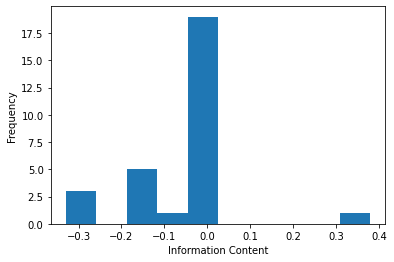

In [70]:
# Distribution of information content of terms
plt.hist(info_content)
plt.xlabel("Information Content")
plt.ylabel("Frequency")
plt.show()

In [69]:
# Select a threshold. All terms with information content below the threshold are put into the stopword list.
threshold = 0.1
inferred_stopword_list = list(info_content.loc[np.abs(info_content)<threshold].index)
inferred_stopword_list

['always',
 'and',
 'but',
 'called',
 'canal',
 'cars',
 'fit',
 'great',
 'house',
 'is',
 'often',
 'prettiest',
 'quite',
 'sailing',
 'streets',
 'they',
 'through',
 'trawlers',
 'worst']